In [73]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import sys
sys.path.append('../scripts')
from paths import SIMULATED_PATH, SIMULATED_DATA_ROOT
from simulated_data import NaiveDataGenerator, CPCDataGenerator, NaiveCrowdsourcingDataGenerator, CPCCrowdsourcingDataGenerator, ACTIONS
from models import NaiveModel, CPCModel
from omegaconf import OmegaConf
from crowdsourcing_probe import NaiveCrowdsourcingProbe, CPCCrowdsourcingProbe, CPCCrowdsourcingEncoderProbe
from sklearn.metrics import average_precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

<b>Predict/report metrics</b>

In [57]:
def report(probe_gen, probe):
    true_labels = {k: [] for k in ACTIONS}
    pred_scores = {k: [] for k in ACTIONS}
    for x_batch, y_batch in probe_gen.train:
        y_batch_pred = probe(x_batch)
        y_batch_pred = y_batch_pred.numpy()
        y_batch = y_batch.numpy()
        for y, y_ in zip(y_batch_pred, y_batch):
            for i, action in enumerate(ACTIONS):
                if y_[i] == -1:
                    continue
                true_labels[action].append(y_[i])
                pred_scores[action].append(y[i])
    true_labels = {k: np.array(v) for k, v in true_labels.items()}
    pred_scores = {k: np.array(v) for k, v in pred_scores.items()}
    df = []
    for action in ACTIONS:
        avg_prec = average_precision_score(true_labels[action], pred_scores[action])
        f1_macro = f1_score(true_labels[action], np.round(pred_scores[action]), average='macro')
        f1_micro = f1_score(true_labels[action], np.round(pred_scores[action]), average='micro')
        df.append({
            'action': action,
            'avg_prec': avg_prec,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro
        })
    df = pd.DataFrame(df)
    return df

<b>Test data balance</b>

Text(0.5, 1.0, 'balance from 0 (negative skewed) to 1 (positive skewed)')

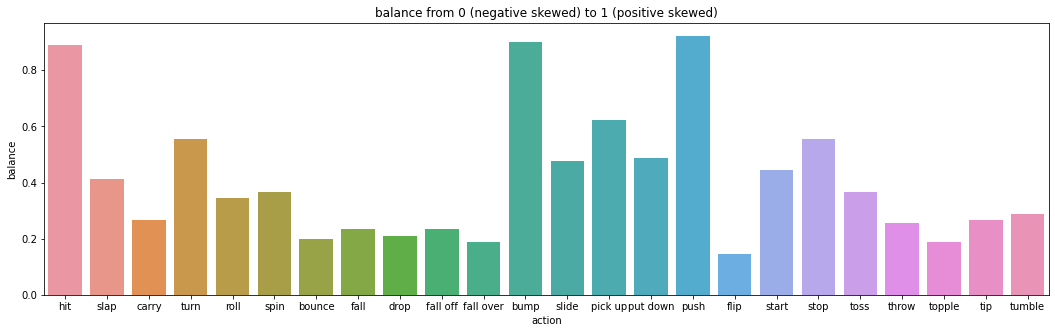

In [82]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
true_labels = {k: [] for k in ACTIONS}
for _, y_batch in probe_gen.test:
    y_batch = y_batch.numpy()
    for y in y_batch:
        for i, action in enumerate(ACTIONS):
            if y[i] == -1:
                continue
            true_labels[action].append(y[i])
true_labels = {k: np.array(v) for k, v in true_labels.items()}
df = []
for action in ACTIONS:
    df.append({
        'action': action,
        'balance': (true_labels[action] == 1).sum() / true_labels[action].shape[0]
    })
df = pd.DataFrame(df)
plt.figure(figsize=(18, 5))
sns.barplot(x='action', y='balance', data=df)
plt.title('balance from 0 (negative skewed) to 1 (positive skewed)')

# Direct prediction

In [131]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
probe = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(ACTIONS), activation='sigmoid')
])
probe_path = f'{SIMULATED_PATH}/outputs/direct_probe.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
direct_df = report(probe_gen, probe)
direct_df

,action,avg_prec,f1_macro,f1_micro
0,hit,0.893208,0.616347,0.872222
1,slap,0.556467,0.616910,0.693056
2,carry,0.887833,0.854873,0.868056
3,turn,0.581809,0.580000,0.591667
4,roll,0.670306,0.583066,0.633333
5,spin,0.418255,0.459705,0.788889
6,bounce,0.545837,0.641761,0.869444
7,fall,0.973835,0.951656,0.962500
8,drop,0.807442,0.856486,0.895833
9,fall off,0.969545,0.944237,0.958333


# Naive model

In [86]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
gen = NaiveDataGenerator(cfg)
model = NaiveModel(cfg)
model(next(iter(gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/weights.h5')
probe = NaiveCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/crowdsourcing_probe_weights.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
naive_df = report(probe_gen, probe)
naive_df

# Naive model (supervised fine-tuning)

In [96]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
gen = NaiveDataGenerator(cfg)
model = NaiveModel(cfg)
model(next(iter(gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/weights.h5')
probe = NaiveCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/naive_supervised_crowdsourcing_probe_unfrozen.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
naive_supervised_df = report(probe_gen, probe)

# Naive model (supervised uninitialized)

In [98]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
gen = NaiveDataGenerator(cfg)
model = NaiveModel(cfg)
model(next(iter(gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/weights.h5')
probe = NaiveCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/naive_supervised_crowdsourcing_probe_unfrozen_uninitialized.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
naive_supervised_uninitialized_df = report(probe_gen, probe)

# Naive model (uninitialized)

In [102]:
best_naive_model_dir = 'naive_batch-size-1024'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = NaiveCrowdsourcingDataGenerator(cfg)
gen = NaiveDataGenerator(cfg)
model = NaiveModel(cfg)
model(next(iter(gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_naive_model_dir}/weights.h5')
probe = NaiveCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/naive_crowdsourcing_probe_uninitialized.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
naive_uninitialized_df = report(probe_gen, probe)

# Contrastive model (lstm probe)

In [106]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/crowdsourcing_probe_weights.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_lstm_df = report(probe_gen, probe)

# Contrastive model (cnn probe)

In [88]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingEncoderProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/crowdsourcing_probe_encoder_weights.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_cnn_df = report(probe_gen, probe)

# Contrastive model (lstm supervised fine-tuning)

In [110]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_supervised_crowdsourcing_probe_unfrozen.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_supervised_lstm_df = report(probe_gen, probe)

# Contrastive model (lstm supervised uninitialized)

In [112]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_supervised_crowdsourcing_probe_unfrozen_uninitialized.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_supervised_uninitialized_lstm_df = report(probe_gen, probe)

# Contrastive model (lstm uninitialized)

In [114]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_crowdsourcing_probe_uninitialized.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_uninitialized_lstm_df = report(probe_gen, probe)

# Contrastive model (cnn supervised fine-tuning)

In [119]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingEncoderProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_supervised_crowdsourcing_probe_unfrozen_encoder.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_supervised_cnn_df = report(probe_gen, probe)

# Contrastive model (cnn supervised uninitialized)

In [118]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingEncoderProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_supervised_crowdsourcing_probe_unfrozen_uninitialized_encoder.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_supervised_uninitialized_cnn_df = report(probe_gen, probe)

# Contrastive model (cnn uninitialized)

In [130]:
best_contrastive_model_dir = 'cpc_batch-size-1024_temperature-1'
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/.hydra/config.yaml')
cfg.model.batch_size = 64
probe_gen = CPCCrowdsourcingDataGenerator(cfg)
gen = CPCDataGenerator(cfg)
model = CPCModel(cfg)
model(next(iter(gen.train)))
model.load_weights(f'{SIMULATED_PATH}/outputs/{best_contrastive_model_dir}/weights.h5')
probe = CPCCrowdsourcingEncoderProbe(cfg, model)
probe_path = f'{SIMULATED_PATH}/outputs/cpc_crowdsourcing_probe_encoder_uninitialized.h5'
probe(next(iter(probe_gen.train))[0])
probe.load_weights(probe_path)
contrastive_uninitialized_cnn_df = report(probe_gen, probe)
contrastive_uninitialized_cnn_df

,action,avg_prec,f1_macro,f1_micro
0,hit,0.967686,0.721362,0.897222
1,slap,0.665895,0.619013,0.711111
2,carry,0.992951,0.950123,0.954167
3,turn,0.747796,0.654499,0.683333
4,roll,0.851149,0.770757,0.777778
5,spin,0.553651,0.538453,0.800000
6,bounce,0.629848,0.723698,0.894444
7,fall,0.995028,0.975224,0.980556
8,drop,0.920825,0.891751,0.922222
9,fall off,0.990574,0.964484,0.973611


## Aggregate statistics

In [133]:
names = ['direct', 'naive', 'contrastive (lstm probe)', 'contrastive (cnn probe)', 'naive supervised fine-tuning',
        'naive supervised uninitialized', 'naive uninitialized', 'contrastive lstm supervised fine-tuning',
        'constrative lstm supervised uninitialized', 'contrastive lstm uninitialized',
        'contrastive cnn supervised fine-tuning', 'contrastive cnn supervised uninitialized',
        'contrastive cnn uninitialized']
dfs = [direct_df, naive_df, contrastive_lstm_df, contrastive_cnn_df, naive_supervised_df, naive_supervised_uninitialized_df,
      naive_uninitialized_df, contrastive_supervised_lstm_df, contrastive_supervised_uninitialized_lstm_df,
      contrastive_uninitialized_lstm_df, contrastive_supervised_cnn_df, contrastive_supervised_uninitialized_cnn_df,
      contrastive_uninitialized_cnn_df]
agg_df = []
for name, df in zip(names, dfs):
    avg_avg_prec = df['avg_prec'].mean()
    avg_f1 = df['f1_macro'].mean()
    agg_df.append({
        'model': name,
        'avg_prec': avg_avg_prec,
        'f1 (macro)': avg_f1
    })
agg_df = pd.DataFrame(agg_df)
agg_df

,model,avg_prec,f1 (macro)
0,direct,0.755923,0.713391
1,naive,0.898827,0.837853
2,contrastive (lstm probe),0.792854,0.737125
3,contrastive (cnn probe),0.802082,0.757815
4,naive supervised fine-tuning,0.857271,0.798313
5,naive supervised uninitialized,0.715193,0.680870
6,naive uninitialized,0.773606,0.739824
7,contrastive lstm supervised fine-tuning,0.875083,0.830191
8,constrative lstm supervised uninitialized,0.840090,0.792268
9,contrastive lstm uninitialized,0.739410,0.715109


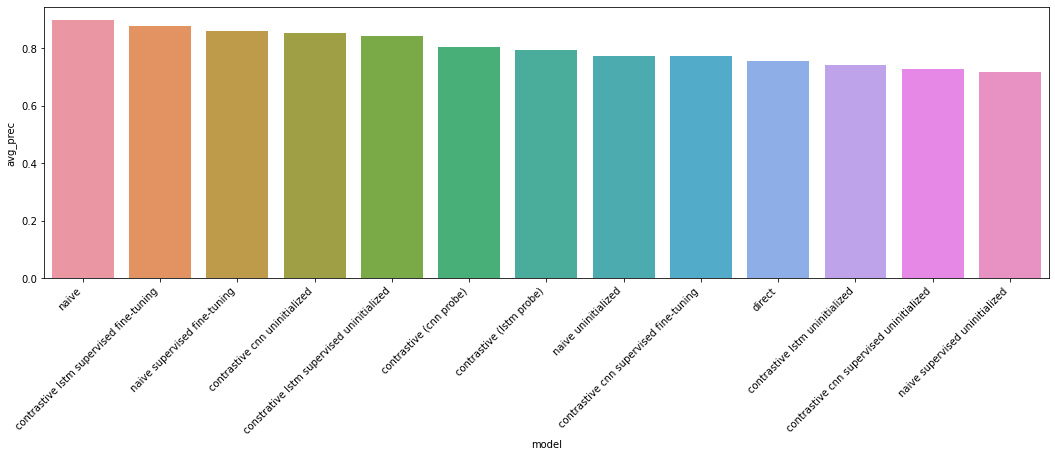

In [134]:
agg_df = agg_df.sort_values(by='avg_prec', ascending=False)
plt.figure(figsize=(18, 5))
plt.xticks(rotation=45, ha='right')
sns.barplot(x='model', y='avg_prec', data=agg_df)